In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *
from pkg.functions import convert2int, convert2str, get_params
from typing import List, Dict, Any

In [2]:
datasets = [1, 4]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
f.get_counts(paths=myPaths, datasets=datasets)

# myDatasetManager = data.DatasetManager(paths=myPaths, datasets=datasets)

# train_loader, test_loader = f.prepare(data_manager=myDatasetManager, batch_size=10)

peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_0

In [3]:
f.check_attributes(paths=myPaths, datasets=f.convert2str(datasets), dir_type='peak')
print(myProcessor.get_parameters())

f.retrieve_attributes(file_path=myPaths.total_paths.water_background[0])

c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\emp

{'clen': 0.15, 'peak': False, 'photon_energy': 6000}

In [4]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 

peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_0

In [14]:
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=None)


train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=15)

peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_0

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam

cfg = {
    "loader": [train_loader, test_loader],
    'num_epochs': 3,
    'batch_size': train_loader.batch_size,
    'optimizer': optimizer,
    'device': device,
    }

peak_config = eval.Peak_Detection_Configuration()
photon_config = eval.Photon_Energy_Configuration()
clen_config = eval.Camera_Length_Configureation()

Model testing and validating: BasicCNN3
Looking for the feature: peak
-- epoch 0
-- Predictions: tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')
-- Image Attribute: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
-- Predictions: tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')
-- Image Attribute: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.

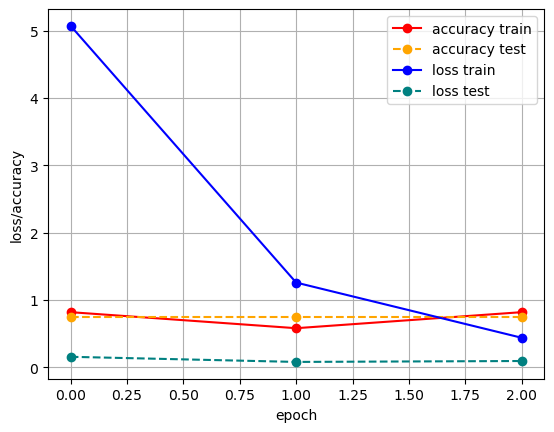

-- Labels      : [[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
-- Predictions : [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


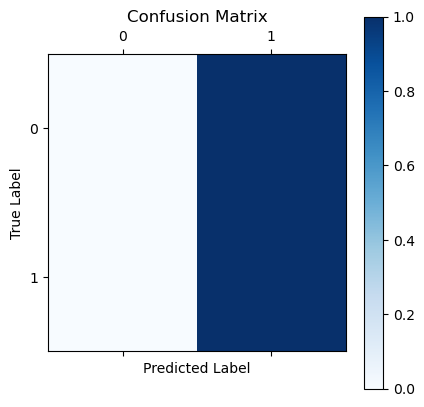

array([[0., 1.],
       [0., 1.]])

In [16]:
a = train_eval.TrainTestModels(cfg, peak_config)
a.epoch_loop()
a.plot_loss_accuracy()
a.plot_confusion_matrix()
a.get_confusion_matrix()

In [ ]:
b = train_eval.TrainTestModels(cfg, photon_config)
b.epoch_loop()
b.plot_loss_accuracy()
b.plot_confusion_matrix()
b.get_confusion_matrix()

Model testing and validating: Multi_Class_CNN1
Looking for the feature: photon_energy
-- epoch 0
Train loss: 0.8997706813471658
Train accuracy: 0.5714285969734192
Test loss: 0.011829757690429687
Test accuracy: 1.0
-- epoch 1


KeyboardInterrupt: 

Model testing and validating: Multi_Class_CNN1
Looking for the feature: clen
-- epoch 0
Train loss: 0.4631336033344269
Train accuracy: 0.800000011920929
Test loss: 0.24182372987270356
Test accuracy: 1.0
-- epoch 1
Train loss: 0.13045930489897728
Train accuracy: 1.0
Test loss: 0.08239501863718032
Test accuracy: 1.0
-- epoch 2
Train loss: 0.05406050916228976
Train accuracy: 1.0
Test loss: 0.03748168908059597
Test accuracy: 1.0
-- epoch 3
Train loss: 0.030483136574427288
Train accuracy: 1.0
Test loss: 0.02360107395797968
Test accuracy: 1.0
-- epoch 4
Train loss: 0.020546758857866127
Train accuracy: 1.0
Test loss: 0.016801757924258708
Test accuracy: 1.0
-- epoch 5
Train loss: 0.014632397575215214
Train accuracy: 1.0
Test loss: 0.014133453369140625
Test accuracy: 1.0
-- epoch 6
Train loss: 0.011153684308131536
Train accuracy: 1.0
Test loss: 0.01083530429750681
Test accuracy: 1.0
-- epoch 7
Train loss: 0.008662151206018669
Train accuracy: 1.0
Test loss: 0.008413200546056033
Test accuracy: 1.

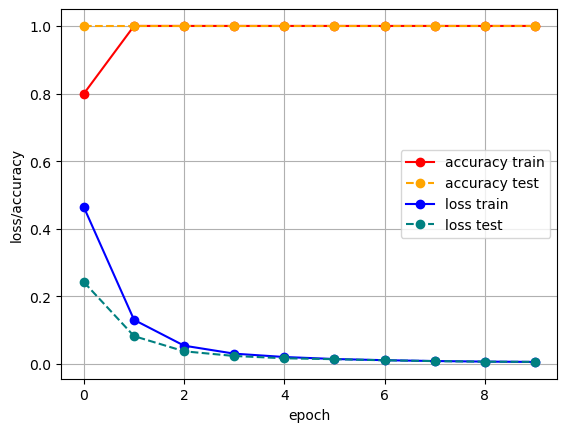

-- Labels      : [2 1 1 1 2 1 1 2 1 1 2 2 1 1 1 1 2 1 2 2 1 1 2 1 1 1 1]
-- Predictions : [2 1 1 1 2 1 1 2 1 1 2 2 1 1 1 1 2 1 2 2 1 1 2 1 1 1 1]


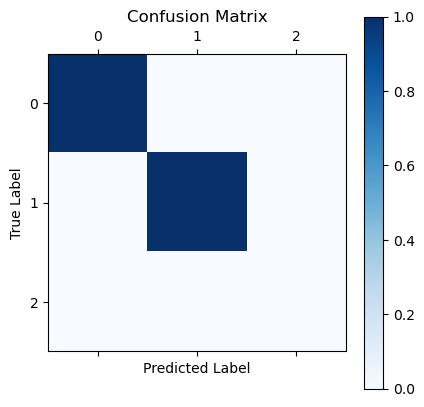

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [ ]:
c = train_eval.TrainTestModels(cfg, clen_config)
c.epoch_loop()
c.plot_loss_accuracy()
c.plot_confusion_matrix()
c.get_confusion_matrix()

In [ ]:
"""
How I want the pipeline to look.

cnn1_path = '../models/cnn1'
cnn2_path = '../models/cnn2'
cnn3_path = '../models/cnn3'

cnn1 = m.BasicCNN1()
cnn2 = m.BasicCNN2()
cnn3 = m.BasicCNN3()

pipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)
pipeline.run(image)
pipeline.evaluate_results(image_path)
"""

"\nHow I want the pipeline to look.\n\ncnn1_path = '../models/cnn1'\ncnn2_path = '../models/cnn2'\ncnn3_path = '../models/cnn3'\n\ncnn1 = m.BasicCNN1()\ncnn2 = m.BasicCNN2()\ncnn3 = m.BasicCNN3()\n\npipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)\npipeline.run(image)\npipeline.evaluate_results(image_path)\n"